# __Advanced Data Mining Techniques with the Titanic__

## Goals of this Notebook

* Walkthrough the fundamental techniques of data mining a classic dataset: the Titanic

## Prerequisite Knowledge

* Familiarity with pandas, numpy, sklearn, etc.

## The Titanic Dataset from Kaggle

The dataset that we will be using to demonstrate some data mining techniques on comes from a Kaggle competition, and as such, a full description of the problem can be found with the following reference:

Will Cukierski. (2012). Titanic - Machine Learning from Disaster. Kaggle. https://kaggle.com/competitions/titanic

The goal of the dataset is simple: use machine learning to create a model that predicts which passengers survived the Titanic shipwreck.

### Columns
For convenience, we offer the names of the columns along with a brief description of each.

* survival: Survival,     0 = No, 1 = Yes
* pclass:	Ticket class,	1 = 1st, 2 = 2nd, 3 = 3rd
* Name: Name of passenger
* sex:	Sex	
* Age:	Age in years	
* sibsp:	# of siblings / spouses aboard the Titanic	
* parch:	# of parents / children aboard the Titanic	
* ticket:	Ticket number	
* fare:	Passenger fare	
* cabin:	Cabin number	
* embarked:	Port of Embarkation,	C = Cherbourg, Q = Queenstown, S = Southampton

# 1. Initial Setup

* Since this is not a Kaggle competition, for the rest of this notebook, we will only focus on the training set and disregard the testing set (even though we will still work with it, we won't analyze it too much).

### Load the data and look at some summary info

* The training set has 891 rows and 11 columns (as expected)

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import random
import warnings
warnings.filterwarnings('ignore')

#First, load the data
train = pd.read_csv(r'train.csv', index_col='PassengerId')
test = pd.read_csv(r'test.csv', index_col='PassengerId')
train.info()
print("----------------------------")
test.info()
print("----------------------------")
print("----------------------------")
print(train.columns)

<class 'pandas.core.frame.DataFrame'>
Index: 891 entries, 1 to 891
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Name      891 non-null    object 
 3   Sex       891 non-null    object 
 4   Age       714 non-null    float64
 5   SibSp     891 non-null    int64  
 6   Parch     891 non-null    int64  
 7   Ticket    891 non-null    object 
 8   Fare      891 non-null    float64
 9   Cabin     204 non-null    object 
 10  Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 83.5+ KB
----------------------------
<class 'pandas.core.frame.DataFrame'>
Index: 418 entries, 892 to 1309
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    418 non-null    int64  
 1   Name      418 non-null    object 
 2   Sex       418 non-null    object 
 3 

In [2]:
#Remove any rows with missing target, as they cannot be used to train
train.dropna(axis=0, subset=['Survived'], inplace=True)

### Partitioning

Now, when working with a dataset, we typically want to create copies of the original data so that there is no accidental overwriting (which could only happen if you save the datasets, which we will not be doing; however, it is still good practice). We also want to make sure that whatever feature engineering we perform on the training set, we also perform it on the testing dataset. Thus, we will seperate our target variable from the training dataset so that we can "stack" the training and testing data into a single new dataframe that we will work with.

In [3]:
#Partition into training, testing, and target subsets
train_sub = train.drop('Survived', axis=1) #This is simply the training set without the target variable
target_sub = train.Survived #This is the target variable
test_sub = test.copy() #This is a copy of the testing data

### Segregation of variables

The next step we will take is to segregate all of the numerical and categorical features by grouping them together and then re-ordering the columns with the numeric features appearing first and the categorical features appearing last. This is for convenience since we will need to work with them seperately.

In [4]:
#Segregate numerical and categorical variables
numerical_vars = []
categorical_vars = []
for col in train_sub.columns:
    if train_sub[col].dtype in ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']:
        numerical_vars.append(col)
    elif train_sub[col].dtype == object:
        categorical_vars.append(col)
print(numerical_vars)
print(categorical_vars)
#Rearange the data
new_order = numerical_vars + categorical_vars
train_sub = train_sub[new_order]
test_sub = test_sub[new_order]

['Pclass', 'Age', 'SibSp', 'Parch', 'Fare']
['Name', 'Sex', 'Ticket', 'Cabin', 'Embarked']


### Stack the training and testing datasets

In [5]:
#Stack the training and testing data so that there are no inconsistencies after data transformation
train_test_data = pd.concat([train_sub, test_sub], axis=0)
train_test_data.shape

(1309, 10)

# 2. Data Visualization

* Visualize the variables via histograms to understand the underlying nature of the distributions

<Axes: xlabel='Age', ylabel='Count'>

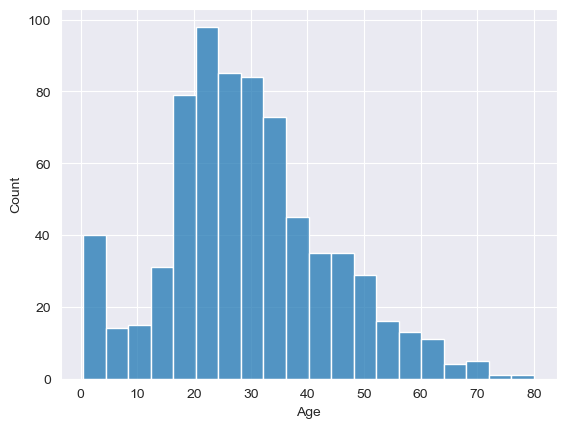

In [6]:
sns.set_style("darkgrid")
sns.histplot(train.Age)

<Axes: xlabel='Pclass', ylabel='Count'>

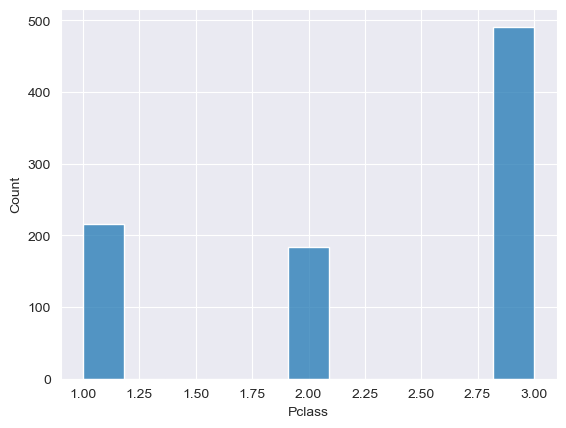

In [7]:
sns.histplot(train.Pclass)

<Axes: xlabel='SibSp', ylabel='Count'>

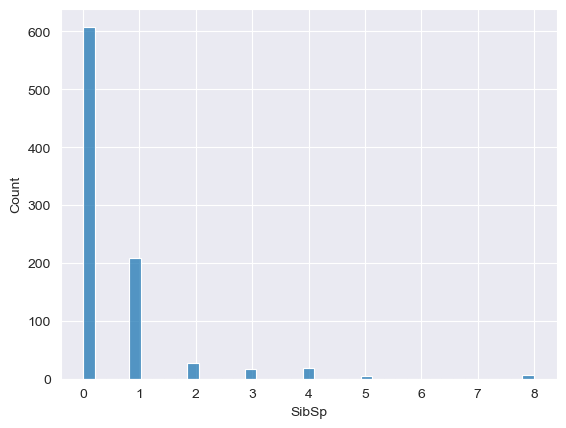

In [8]:
sns.histplot(train.SibSp)

<Axes: xlabel='Parch', ylabel='Count'>

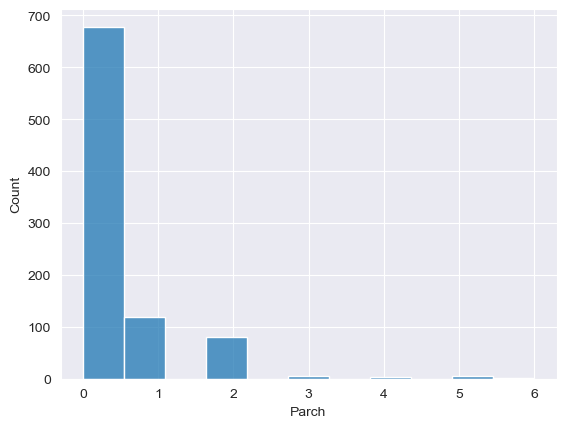

In [9]:
sns.histplot(train.Parch)

<Axes: xlabel='Fare', ylabel='Count'>

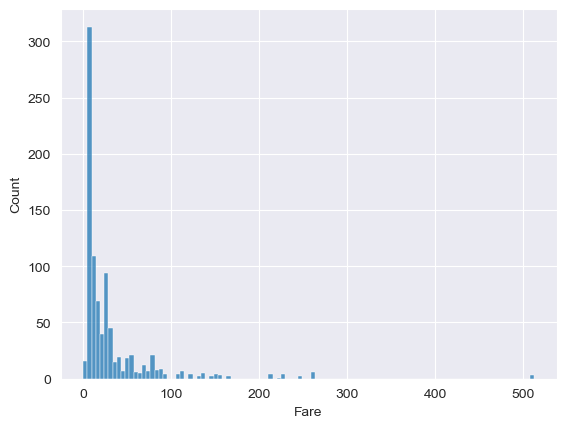

In [10]:
sns.histplot(train.Fare)

## Analyze the target variable

We now wish to understand the class imbalance of our target variable, which there does seem to be. Specifically, we can see that about 62% of all of the passengers on the Titanic dies, leaving only about 38% to survive.

* This is our first baseline model. Meaning, that if we had a model that predicted everyone on the Titanic had died, we would expect it to have about a 62% accuracy.

Percentage of passengers who died: 0.6161616161616161


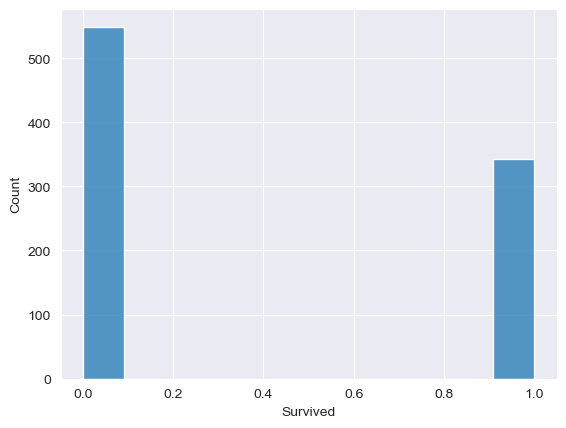

In [11]:
#Target variable
sns.histplot(train.Survived)
num_survived = np.sum(train[train['Survived']==1]['Survived'])
num_died = train.shape[0] - num_survived
print("Percentage of passengers who died: "+str(num_died / (num_survived+num_died)))

### Differentiate on the Sex of the passenger

Now, let's see how much of an increase we observe in our model's accuracy if we take into account a single other variable: Sex. Very quickly, we notice that about 81% of men on the Titanic died, whereas only 26% of the women did. Thus, if we change our baseline model from predicting that everyone dies to predicting that all men die and all women survive, we can increase the accuracy of our model substantially.

* Accounting for Sex, we obtain a new baseline model that has an accuracy of around 78% (an increase of 16%).

Total number of men aboard: 577
Percentage of men who died: 0.8110918544194108
Total number of women aboard: 314
Percentage of women who died: 0.25796178343949044
Accuracy of baseline model taking Sex into account: 0.7867564534231202


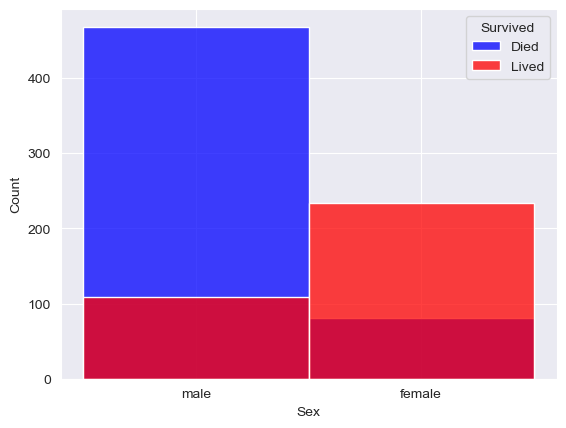

In [12]:
num_male_survived = np.sum(train[train['Survived']==1]['Sex']=='male')
num_male = np.sum(train['Sex']=='male')
print("Total number of men aboard: "+str(num_male))
prop_male_died = (num_male - num_male_survived) / num_male
print("Percentage of men who died: "+str(prop_male_died))
num_female_survived = np.sum(train[train['Survived']==1]['Sex']=='female')
num_female = np.sum(train['Sex']=='female')
print("Total number of women aboard: "+str(num_female))
prop_female_died = (num_female - num_female_survived) / num_female
print("Percentage of women who died: "+str(prop_female_died))
#Distributions of the survived with sex features
sns.histplot(train[train['Survived']==0]['Sex'], color = 'blue', label = 'Died')
sns.histplot(train[train['Survived']==1]['Sex'], color = 'red', label = 'Survived')
plt.legend(title='Survived', labels=['Died', 'Lived'])
print("Accuracy of baseline model taking Sex into account: "+str((num_male/(num_male+num_female))*prop_male_died + (num_female/(num_male+num_female))*(1-prop_female_died)))

### Visualize some other variables when differentiating on Survived

* __Pclass__: We see that 1st class had the highest survival rate, 2nd class had comparable survival rates, and 3rd class had the worst survival rate.
* __SibSp__: Passengers who had no siblings or spouses had the highest death rate whereas those with a single sibling or spouse had the lowest. It also seems that those with large families had low survival rates.
* __Parch__: Passengers with no parents or children had the lowest survival rate whereas those with 1 or 2 parents or children had the highest survival rate.
* __Fare__: Passengers with low ticket fares had the lowest survival rate whereas those who had higher fare costs had better chances of survival on average. This is highly correlated with the class.

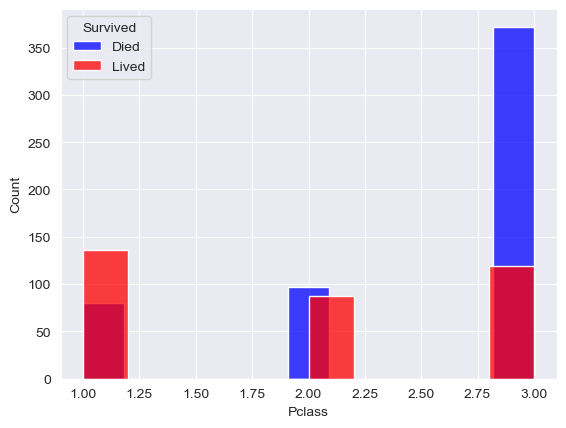

In [13]:
#Distributions of the survived with Pclass features
sns.histplot(train[train['Survived']==0]['Pclass'], color = 'blue', label = 'Died')
sns.histplot(train[train['Survived']==1]['Pclass'], color = 'red', label = 'Survived')
plt.legend(title='Survived', labels=['Died', 'Lived'])

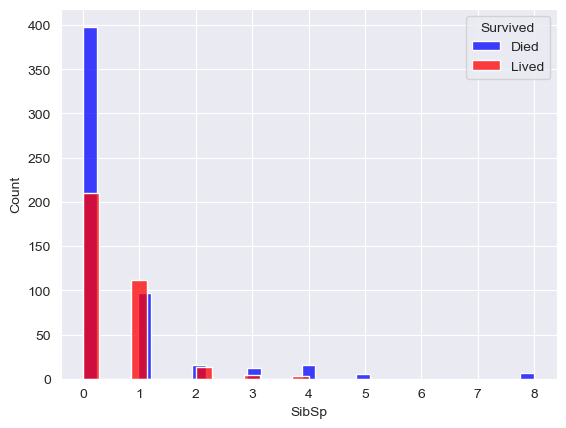

In [14]:
#Distributions of the survived with SibSp features
sns.histplot(train[train['Survived']==0]['SibSp'], color = 'blue', label = 'Died')
sns.histplot(train[train['Survived']==1]['SibSp'], color = 'red', label = 'Survived')
plt.legend(title='Survived', labels=['Died', 'Lived'])

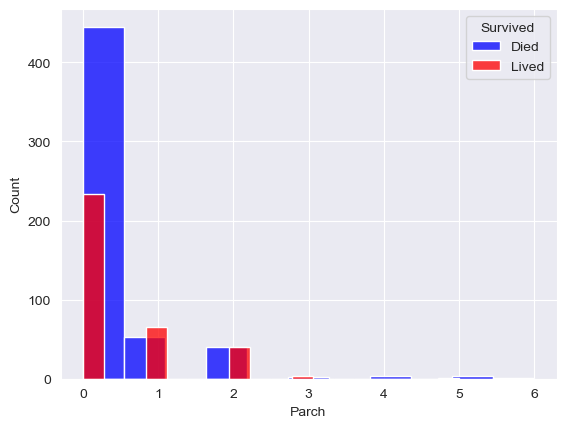

In [15]:
#Distributions of the survived with Parch features
sns.histplot(train[train['Survived']==0]['Parch'], color = 'blue', label = 'Died')
sns.histplot(train[train['Survived']==1]['Parch'], color = 'red', label = 'Survived')
plt.legend(title='Survived', labels=['Died', 'Lived'])

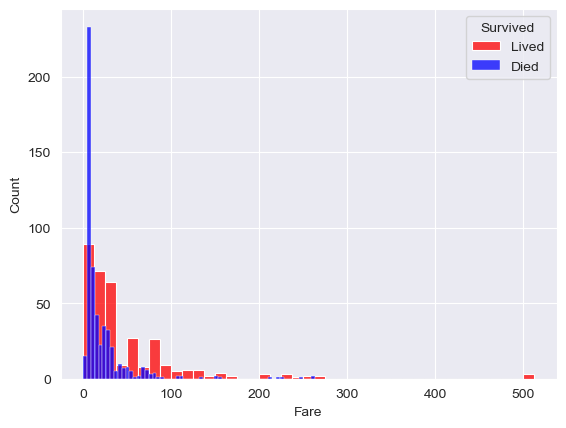

In [16]:
#Distributions of the survived with Fare features
sns.histplot(train[train['Survived']==1]['Fare'], color = 'red', label = 'Survived')
sns.histplot(train[train['Survived']==0]['Fare'], color = 'blue', label = 'Died')
plt.legend(title='Survived', labels=['Lived', 'Died'])

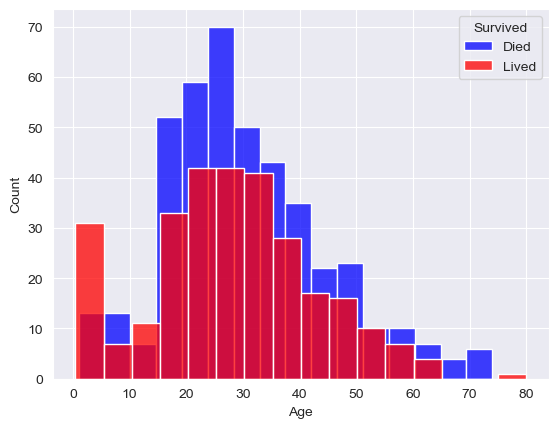

In [17]:
#Distributions of the survived with Age features
sns.histplot(train[train['Survived']==0]['Age'], color = 'blue', label = 'Died')
sns.histplot(train[train['Survived']==1]['Age'], color = 'red', label = 'Survived')
plt.legend(title='Survived', labels=['Died', 'Lived'])

# 3. Data Pre-processing / Cleaning / Feature Engineering
## Pre-processing Numerical Data

### Identify the feature columns that have missing entries

This is the first this we want to look at when handling data. Further, we must determnine how we want to handle the missing entries.

* Only 'Age' and 'Fare' are missing values for the numerical features. Specifically, 'Age' has 263 missing and 'Fare' has only 1 missing.

In [18]:
#Identify the columns with missing values
numerical_missing = []
numerical_missing = [col for col in train_test_data[numerical_vars] if train_test_data[col].isnull().any()]
print('Numerical features with missing data: '+str(numerical_missing))
print('Age: '+str(train_test_data['Age'].isnull().sum()))
print('Fare: '+str(train_test_data['Fare'].isnull().sum()))

Numerical features with missing data: ['Age', 'Fare']
Age: 263
Fare: 1


* Since 'Fare' is only missing 1 entry, we will simply replace it with the median of the distribution (which is 14.4542).

In [19]:
#There is only one missing value for 'Fare', so let's replace it with the median; this individual could have snuck on board?
print('Median of Fare: '+str(train_test_data['Fare'].median()))
train_test_data['Fare'] = train_test_data.Fare.fillna(train_test_data.groupby(['Parch','SibSp','Pclass']).Fare.transform('median'))

Median of Fare: 14.4542


#### How do we fill in the 263 missing values for 'Age'?

* Let's start by looking at correlations of the variables to determine the best features that are related to 'Age'

In [20]:
#To determine how to fill in missing 'Age' values, let's look at the correlations (with the numerical variables) to have a statistically informed decision
Cor = train_test_data[numerical_vars].corr().sort_values(by='Age', ascending=False).round(3)
print('Correlations with Age: \n'+str(Cor['Age']))

Correlations with Age: 
Age       1.000
Fare      0.177
Parch    -0.151
SibSp    -0.244
Pclass   -0.408
Name: Age, dtype: float64


#### Impute the median of 'Age' across 'Pclass' and 'Sex' (The two strongest predictors for 'Age')

Doing this will give us a better approximation of the missing values than if we simply replaced the values with just the median of 'Age'.

In [21]:
#Thus, since 'Pclass' is the most highly correlated variable, we will use that along with 'Sex' to impute the median
train_test_data['Age'] = train_test_data.Age.fillna(train_test_data.groupby(['Sex','Pclass']).Age.transform('median'))

### Heatmap visualization to look at correlations

<Axes: >

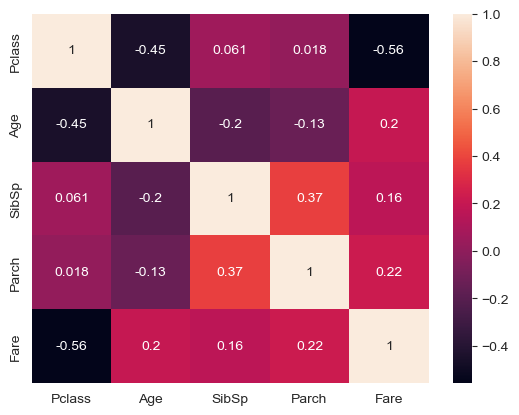

In [22]:
#Correlation Analysis of the numerical variables
Cor = train_test_data[numerical_vars].corr().round(3)
#Create heat map of variables
cor_columns = Cor.head(5).index
cor_coef = np.corrcoef(train_test_data[cor_columns].values.T)
sns.heatmap(cor_coef, annot=True, yticklabels=cor_columns.values, xticklabels=cor_columns.values)

### Use binning to transform 'Age' and 'Fare' into categorical features

* This is one way of handling numerical features (and it so happens to be the best choice for this dataset). The alternative option would be to perform a transform on the data to make sure that the distributions are 'well-behaved'. However, to decide which to apply in practice, one must compare the different approaches (since this is not a single-answer-to-all scenario). This is why data mining is more of an art than a science ;)

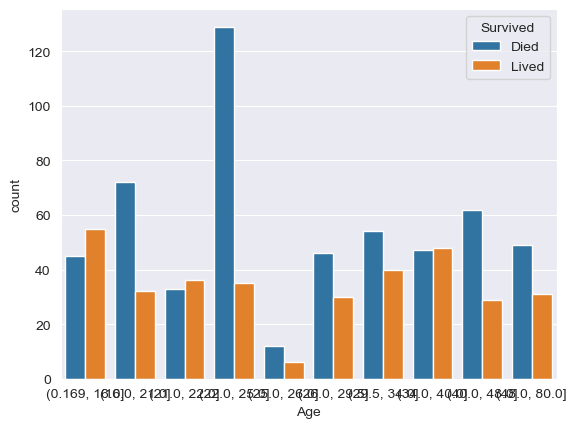

In [23]:
#Now use bining to transform 'Age' into a categorical variable
train_test_data['Age'] = pd.qcut(train_test_data['Age'], 10)
#Plot the new feature
sns.countplot(x='Age', hue=target_sub, data=train_test_data.iloc[:len(target_sub), :])
plt.legend(title='Survived', labels=['Died', 'Lived'])

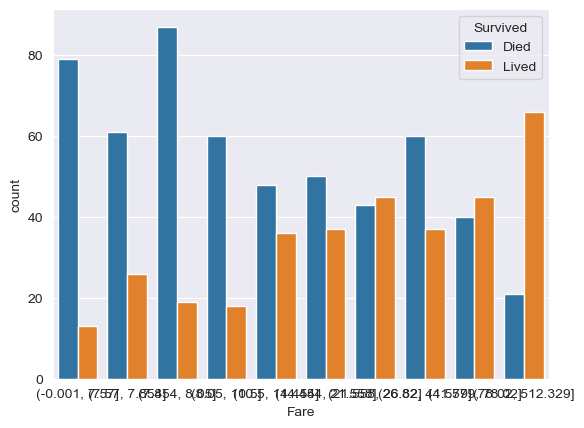

In [24]:
#Now use bining to transform 'Fare' into a categorical variable
train_test_data['Fare'] = pd.qcut(train_test_data['Fare'], 10)
#Plot the new feature
sns.countplot(x='Fare', hue=target_sub, data=train_test_data.iloc[:len(target_sub), :])
plt.legend(title='Survived', labels=['Died', 'Lived'])

## Feature Engineering Numerical Data

We will now create a series of features that we think will be useful predictors that will add information to our models. Specifically, we will create 'FamilySize' (the number of siblings, spouses, parents, and children, including the passenger themselves) and 'NameLength' (the length of the passengers names) features.

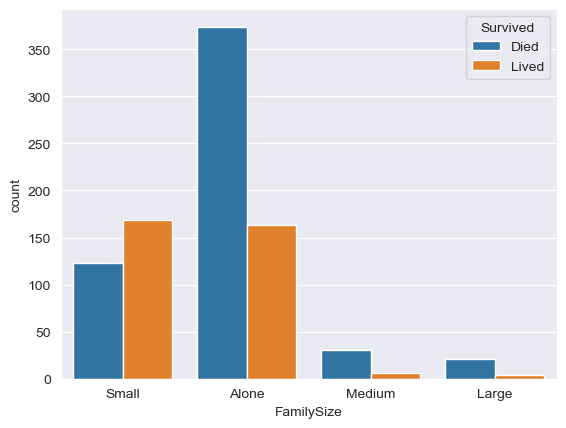

In [25]:
#Create 'FamilySize' variable
train_test_data['FamilySize'] = train_test_data['SibSp'] + train_test_data['Parch'] + 1
train_test_data['FamilySize'].value_counts()
fam_map = {1:'Alone',2:'Small',3:'Small',4:'Small',5:'Medium',6:'Medium',7:'Large',8:'Large',11:'Large'}
train_test_data['FamilySize'] = train_test_data['FamilySize'].map(fam_map)
train_test_data['FamilySize'].value_counts()
#Plot the new feature
sns.countplot(x='FamilySize', hue=target_sub, data=train_test_data.iloc[:len(target_sub), :])
plt.legend(title='Survived', labels=['Died', 'Lived'])

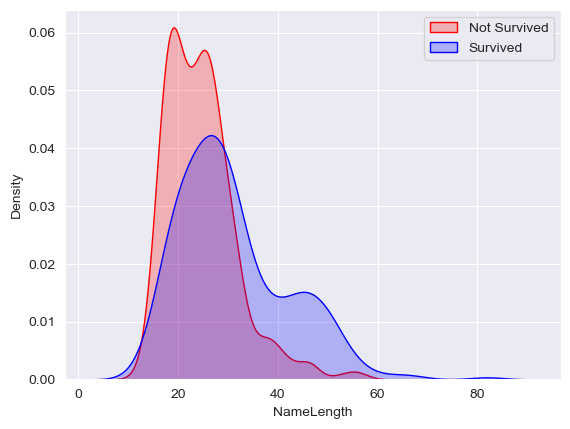

In [26]:
#Create 'NameLength' variable and bin it
train_test_data['NameLength'] = train_test_data['Name'].apply(lambda x : len(x))
#Plot the new feature
sns.kdeplot(train_test_data['NameLength'][:len(target_sub)][(target_sub == 0)], color='Red', shade=True)
sns.kdeplot(train_test_data['NameLength'][:len(target_sub)][(target_sub == 1)], color='Blue', shade=True).legend(['Not Survived', 'Survived'])

#### Bin the new 'NameLength' feature that we created

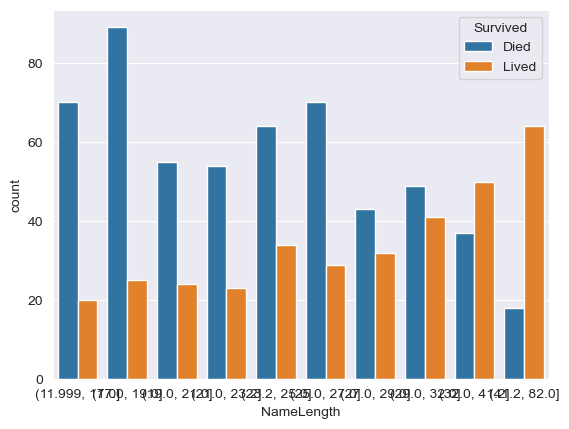

In [27]:
train_test_data['NameLength'] = pd.qcut(train_test_data['NameLength'], 10)
#Plot the new feature
sns.countplot(x='NameLength', hue=target_sub, data=train_test_data.iloc[:len(target_sub), :])
plt.legend(title='Survived', labels=['Died', 'Lived'])

## Pre-Processing Categorical Data

### Identify the feature columns that have missing values

* Only 'Cabin' and 'Embarked' have missing values. Specifically, 'Cabin' is missing 1014 entries and 'Embarked' is missing 2.
* 'Cabin' is going to be a problem since most of the data is missing and we will not be able to simply impute  it.

In [28]:
#Identify the columns with missing values
catagorical_missing = []
catagorical_missing = [col for col in train_test_data[categorical_vars] if train_test_data[col].isnull().any()]
print('Categorical features with missing data: '+str(catagorical_missing))
print('Cabin: '+str(train_test_data['Cabin'].isnull().sum()))
print('Embarked: '+str(train_test_data['Embarked'].isnull().sum()))

Categorical features with missing data: ['Cabin', 'Embarked']
Cabin: 1014
Embarked: 2


* Since 'Embarked' is missing so few entries, we can simply replace them with the mode of the feature.
* Since 'Cabin' is missing such a large portion of the entries, we will simply create a new category in the feature called NA to indicate that we do not know the cabin of the passenger. Perhaps there will be some correlation between survival rate and those whose cabin is recorded.

In [29]:
#Replace the missing 'Embarked' values with the mode
train_test_data['Embarked'] = train_test_data['Embarked'].fillna(train_test_data['Embarked'].mode()[0])
#Replace the missing 'Cabin' values with 'NA'
train_test_data['Cabin'] = train_test_data['Cabin'].fillna('NA')

## Feature Engineering Categorical Data

We will now create a series of features that we think will be useful predictors that will add information to our models. Specifically, we will create 'Title' (the title of the passenger created from the 'Name' feature), 'CLetter' (first letter of the 'Cabin'), and 'Zone' (grouping 'CLetter' by 'Pclass') features.

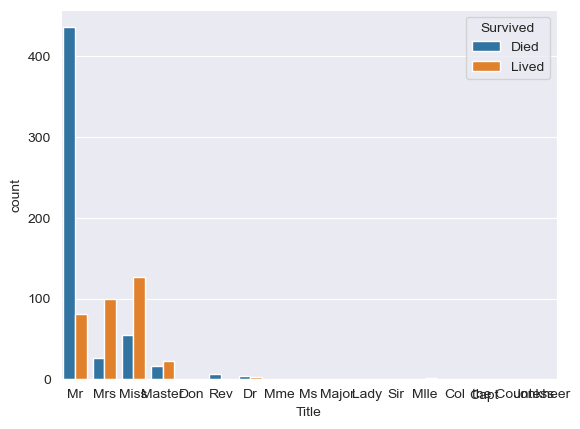

In [30]:
#Determine the title of each person
train_test_data['Title'] = train_test_data.Name.str.split(',').str[1].str.split('.').str[0].str.strip()
train_test_data['Title'].value_counts()
train_test_data['Title'].unique()
#Plot the new feature
sns.countplot(x='Title', hue=target_sub, data=train_test_data.iloc[:len(target_sub), :])
plt.legend(title='Survived', labels=['Died', 'Lived'])

#### Bin the new 'Title' feature that was created

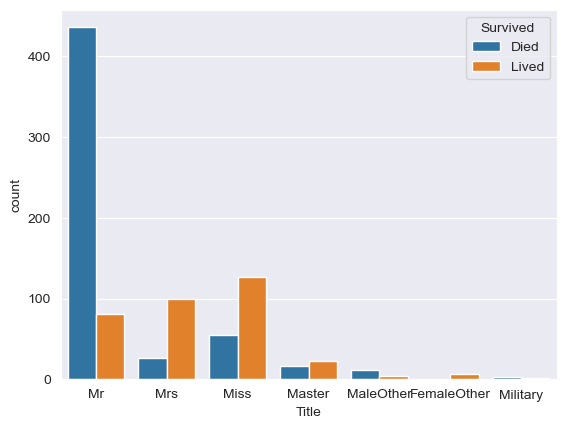

In [31]:
#Bin the column 'Title'
Title_list = []
for title in train_test_data['Title']:
    if title == 'Mr':
        Title_list.append(title)
        continue
    elif title == 'Miss':
        Title_list.append(title)
        continue
    elif title == 'Mrs':
        Title_list.append(title)
        continue
    elif title == 'Master':
        Title_list.append(title)
        continue
    elif title in ['Major','Col','Capt']:
        Title_list.append('Military')
        continue
    elif title in ['Lady','the Countess','Dona','Mlle','Ms','Mme']:
        Title_list.append('FemaleOther')
        continue
    elif title in ['Don','Rev','Dr','Sir','Jonkheer']:
        Title_list.append('MaleOther')
        continue
train_test_data = train_test_data.drop('Title', axis=1)
train_test_data['Title'] = Title_list
train_test_data['Title'].value_counts()
#Plot the new feature
sns.countplot(x='Title', hue=target_sub, data=train_test_data.iloc[:len(target_sub), :])
plt.legend(title='Survived', labels=['Died', 'Lived'])

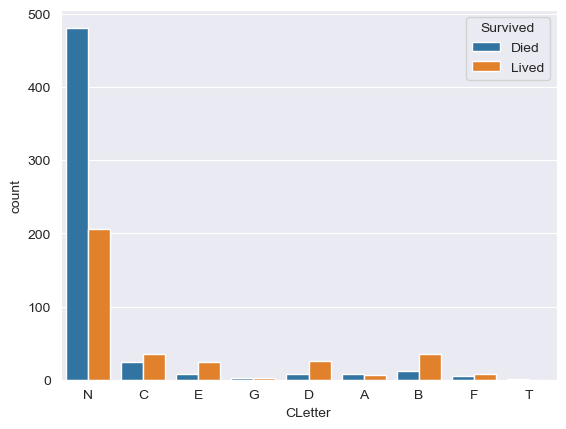

In [32]:
#Create a column for the first letter of the cabin column, i.e., 'CLetter'
cabin_letters = []
for cabin in train_test_data['Cabin']:
    if cabin == 'NA':
        cabin_letters.append('N')
    else:
        cabin_letters.append(cabin[0])
train_test_data['CLetter'] = cabin_letters
train_test_data['CLetter'].value_counts()
#Plot the new feature
sns.countplot(x='CLetter', hue=target_sub, data=train_test_data.iloc[:len(target_sub), :])
plt.legend(title='Survived', labels=['Died', 'Lived'])

#### Bin the new 'CLetter' feature that was created

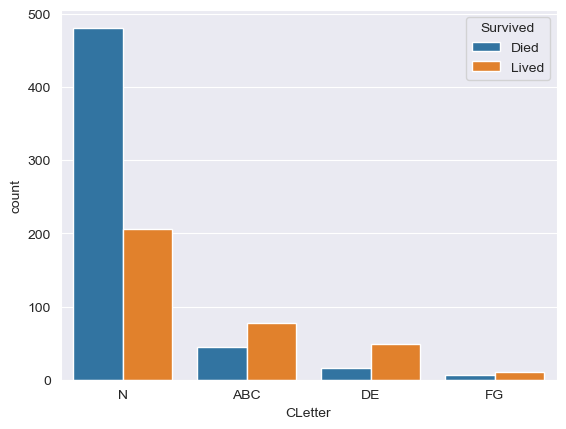

In [33]:
#Bin the cabins together
train_test_data['CLetter'] = train_test_data['CLetter'].replace(['A','B','C','T'], 'ABC')
train_test_data['CLetter'] = train_test_data['CLetter'].replace(['D','E'], 'DE')
train_test_data['CLetter'] = train_test_data['CLetter'].replace(['F','G'], 'FG')
#Plot the new feature
sns.countplot(x='CLetter', hue=target_sub, data=train_test_data.iloc[:len(target_sub), :])
plt.legend(title='Survived', labels=['Died', 'Lived'])

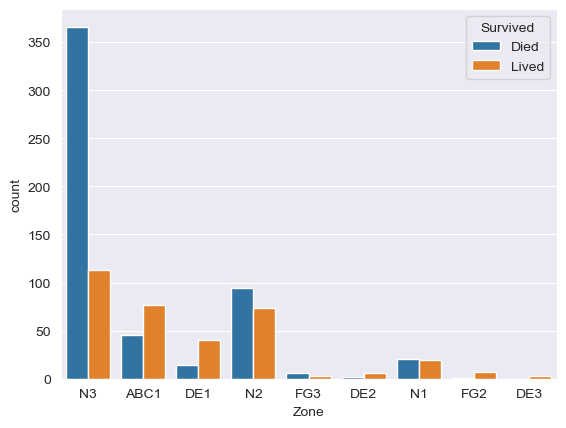

In [34]:
#Create a 'Zone' column that groups 'CLetter' by 'Pclass'
Zone = []
index = 1
for row in train_test_data['CLetter']:
    Zone.append(row + train_test_data['Pclass'][index].astype(str))
    index += 1
train_test_data['Zone'] = Zone
train_test_data['Zone'].value_counts()
#Plot the new feature
sns.countplot(x='Zone', hue=target_sub, data=train_test_data.iloc[:len(target_sub), :])
plt.legend(title='Survived', labels=['Died', 'Lived'])

#### Bin the new 'Zone' feature that was created

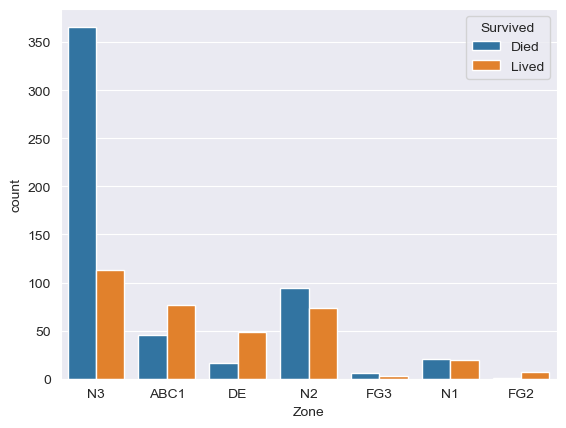

In [35]:
#Bin the DE zones
train_test_data['Zone'] = train_test_data['Zone'].replace(['DE2','DE3','DE1'], 'DE')
#Plot the new feature
sns.countplot(x='Zone', hue=target_sub, data=train_test_data.iloc[:len(target_sub), :])
plt.legend(title='Survived', labels=['Died', 'Lived'])

# 4. Post-Processing / One-Hot & Label Encoding, etc.

Now that we've finished all of our feature engineering and cleaning the data, we are ready to prepare the data for modeling. This will include the following.

* Removing columns that will not be of any more use (such as 'Ticket', 'Name', 'Cabin', 'SibSp', and 'Parch') since we have already mined these features.
* __Label Encode__ the __Ordinal Features__ (features that have some sort of inherent numerical ranking to them, such as 'NameLength' and 'Fare' for example).
     * __Label Encoding__ will assign a discrete numerical value to the categories of the features (thus, they can be 'ordered' by this value).
* __One-Hot Encode__ the __Nominal Features__ (features that have no discernable ranking structure, such as 'Zone', 'CLetter', and 'Title' for example).
    * __One-Hot Encoding__ will generate new a new column feature for EACH category of a nominal feature. Each of these new features will be binary variables, indicating whether or not the selected entry falls into that category or not. As you can imagine, this may create MANY new features.

Notice that we now have a total of 15 features (we added a total of 5 new features).

In [36]:
#At this point, let's look at our data again and select the final columns
print(train_test_data.shape)
print(train_test_data.columns)
train_test_data.head()

(1309, 15)
Index(['Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'Name', 'Sex', 'Ticket',
       'Cabin', 'Embarked', 'FamilySize', 'NameLength', 'Title', 'CLetter',
       'Zone'],
      dtype='object')


,Pclass,Age,SibSp,Parch,Fare,Name,Sex,Ticket,Cabin,Embarked,FamilySize,NameLength,Title,CLetter,Zone
PassengerId,,,,,,,,,,,,,,,
1,3,"(21.0, 22.0]",1,0,"(-0.001, 7.57]","Braund, Mr. Owen Harris",male,A/5 21171,NA,S,Small,"(21.0, 23.2]",Mr,N,N3
2,1,"(34.0, 40.0]",1,0,"(41.579, 78.02]","Cumings, Mrs. John Bradley (Florence Briggs Th...",female,PC 17599,C85,C,Small,"(41.2, 82.0]",Mrs,ABC,ABC1
3,3,"(25.0, 26.0]",0,0,"(7.854, 8.05]","Heikkinen, Miss. Laina",female,STON/O2. 3101282,NA,S,Alone,"(21.0, 23.2]",Miss,N,N3
4,1,"(34.0, 40.0]",1,0,"(41.579, 78.02]","Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,113803,C123,S,Small,"(41.2, 82.0]",Mrs,ABC,ABC1
5,3,"(34.0, 40.0]",0,0,"(7.854, 8.05]","Allen, Mr. William Henry",male,373450,NA,S,Alone,"(23.2, 25.0]",Mr,N,N3


In [37]:
#Remove the columns that are of no more use
train_test_data.drop(['Ticket','Name','Cabin','SibSp','Parch'], axis=1, inplace=True)
print(train_test_data.shape)
print(train_test_data.columns)

(1309, 10)
Index(['Pclass', 'Age', 'Fare', 'Sex', 'Embarked', 'FamilySize', 'NameLength',
       'Title', 'CLetter', 'Zone'],
      dtype='object')


#### Perform the Label Encoding

In [38]:
#Label Encode the variables that have some numerical heiarchy to them (ordinal features)
from sklearn.preprocessing import LabelEncoder
label_encode_vars = ['Age','Fare','NameLength']
label_encoder = LabelEncoder()
for col in label_encode_vars:
    train_test_data[col] = label_encoder.fit_transform(train_test_data[col])
train_test_data.head()

,Pclass,Age,Fare,Sex,Embarked,FamilySize,NameLength,Title,CLetter,Zone
PassengerId,,,,,,,,,,
1,3,2,0,male,S,Small,3,Mr,N,N3
2,1,7,8,female,C,Small,9,Mrs,ABC,ABC1
3,3,4,2,female,S,Alone,3,Miss,N,N3
4,1,7,8,female,S,Small,9,Mrs,ABC,ABC1
5,3,7,2,male,S,Alone,4,Mr,N,N3


#### Perform the One-Hot Encoding

* Notice that this creates many new features. Specifically, we went from 10 features to 31... As you can imagine, we will have to do a little work with these new features to verify that they will be useful.

In [39]:
#One-Hot encoding features that have no discernable ranking nature
train_test_data = pd.get_dummies(train_test_data)
print(train_test_data.shape)
train_test_data.head()

(1309, 31)


,Pclass,Age,Fare,NameLength,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,FamilySize_Alone,...,CLetter_DE,CLetter_FG,CLetter_N,Zone_ABC1,Zone_DE,Zone_FG2,Zone_FG3,Zone_N1,Zone_N2,Zone_N3
PassengerId,,,,,,,,,,,,,,,,,,,,,
1,3,2,0,3,False,True,False,False,True,False,...,False,False,True,False,False,False,False,False,False,True
2,1,7,8,9,True,False,True,False,False,False,...,False,False,False,True,False,False,False,False,False,False
3,3,4,2,3,True,False,False,False,True,True,...,False,False,True,False,False,False,False,False,False,True
4,1,7,8,9,True,False,False,False,True,False,...,False,False,False,True,False,False,False,False,False,False
5,3,7,2,4,False,True,False,False,True,True,...,False,False,True,False,False,False,False,False,False,True


### Remove features that have a single value as the predominant value (greater than 95%-99%)

* This is especially necessary after one-hot encoding, as there is a possibility (depending on how thorough we were with our feature engineering and cleaning) that there will be several new columns that have mostly just a single value.
* The accumulation of features with predominant single-values (in particular those that may have been created over one-hot encoding) may lead to potential overfitting.
* In other words, the regression models may attempt to fit to a very limited number of single-values present in such features and, as a consequence, their overall performance could be negatively impacted.
* Notice that in doing this, we will drop 4 features.

In [40]:
#Remove features with single-value predominant values
features_to_be_dropped = []
for col in train_test_data.columns:
    val_counts = train_test_data[col].value_counts()
    zero_counts = val_counts.iloc[0]
    if (zero_counts / train_test_data.shape[0] > 0.99):
        features_to_be_dropped.append(col)
print(features_to_be_dropped)
train_test_data = train_test_data.drop(features_to_be_dropped, axis=1).copy()
print(train_test_data.shape)

['Title_FemaleOther', 'Title_Military', 'Zone_FG2', 'Zone_FG3']
(1309, 27)


### Seperate the training and testing datasets

In [41]:
#Now, seperate the training and testing sets from train_test_features
X_train = train_test_data.iloc[:len(target_sub), :]
X_test = train_test_data.iloc[len(target_sub):, :]
y_train = target_sub.copy()
#Join the training data and the target feature
X_training_data = pd.concat([X_train, y_train], axis=1)
print('Shape of training set: '+str(X_training_data.shape))
print('Shape of testing set: '+str(X_test.shape))

Shape of training set: (891, 28)
Shape of testing set: (418, 27)


### Standardize the datasets

A good reference for the necessity of standardizing data can be found at

https://builtin.com/data-science/when-and-why-standardize-your-data

* This is an important step. Data standardization comes into the picture when features of the input data set have large differences between their ranges, or simply when they are measured in different units (e.g., pounds, meters, miles, etc.).
* These differences in the ranges of initial features cause trouble for many machine learning models. For example, for the models that are based on distance computation (such as KNN, SVM, PCA, Linear Regression, etc), if one of the features has a broad range of values, the distance will be governed by this particular feature.

In [42]:
#Standardize the data
from sklearn.preprocessing import StandardScaler
standardizer = StandardScaler()
X_train = pd.DataFrame(standardizer.fit_transform(X_train), columns=X_train.columns)
X_test = pd.DataFrame(standardizer.transform(X_test), columns=X_test.columns)
X_training_data = pd.concat([X_train, y_train], axis=1)
X_training_data = X_training_data.iloc[:-1,:]

# 5. Machine Learning

We have now arrived to the modeling phase. Our data has been processed and we are ready to make predictions.

In [43]:
#To start, generate a simple 80%-20% train-test split of the data
from sklearn.model_selection import train_test_split
X_train_full, X_valid_full, y_train_full, y_valid_full = train_test_split(X_train, y_train, train_size=0.8, test_size=0.2, random_state=42)
print('Shape of training set: '+str(X_train_full.shape))
print('Shape of validation set: '+str(X_valid_full.shape))

Shape of training set: (712, 27)
Shape of validation set: (179, 27)


### Model 1. Logistic Regression Model

This is the first ML model that we will implement.

* Recall that our baseline model we obtained had an accuracy of around 78.7%.
* This first model yields an accuracy on the validation set of around 82.1%; an improvement of about 3.4%.

In [44]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
#Logistic Regression Model
from sklearn.linear_model import LogisticRegression
lg_mod = LogisticRegression().fit(X_train_full, y_train_full)
lg_mod.score(X_valid_full, y_valid_full)
lg_train_preds = lg_mod.predict(X_train_full)
lg_valid_preds = lg_mod.predict(X_valid_full)
print("Accuracy on Training set: ", lg_mod.score(X_train_full, y_train_full))
print("Accuracy on Validation set: ", lg_mod.score(X_valid_full, y_valid_full))
print("Training set Confusion matrix:")
print(confusion_matrix(y_train_full, lg_train_preds))
print("Validation set Confusion matrix:")
print(confusion_matrix(y_valid_full, lg_valid_preds))

Accuracy on Training set:  0.8356741573033708
Accuracy on Validation set:  0.8212290502793296
Training set Confusion matrix:
[[391  53]
 [ 64 204]]
Validation set Confusion matrix:
[[87 18]
 [14 60]]


## Proper Cross-Validation Function

Here, we write a function that properly cross validates the model and returns a 95% confidence interval for the accuracy that we can expect from our model using the Student-T distribution.

In [45]:
####################### Proper Cross-Validation Function ######################
import scipy.stats as st
from sklearn.model_selection import cross_val_score
def cross_val_stats(X_train, y_train, model, cv):
    scores = cross_val_score(model, X_train, y_train, cv=cv)
    lower_cl, upper_cl = st.t.interval(confidence=0.95, df=cv-1, loc=np.mean(scores), scale=st.sem(scores))
    print('Scores: ', scores)
    print('Mean: ', np.mean(scores))
    print('95% Confidence Interval: [{}, {}]'.format(lower_cl.round(4), upper_cl.round(4)))
    return scores

#### Now, let's properly cross-validate the logistic regression model

* For all of our models we will use a 10-fold CV.

In [46]:
#Cross Validate the logistic model (Correct way)
log_model = LogisticRegression()
log_model_scores = cross_val_stats(X_train, y_train, log_model, 10)

Scores:  [0.82222222 0.84269663 0.7752809  0.85393258 0.84269663 0.7752809
 0.84269663 0.80898876 0.8988764  0.85393258]
Mean:  0.8316604244694131
95% Confidence Interval: [0.8046, 0.8587]


## Model 2. Random Forest

We now test an out-of-the-box random forest model and compare it to the logistic regression model.

* As can be seen, the RF model seems to overfit the data, and as a result, has a worse performance than the logistic model.

In [47]:
#Random Forest model
from sklearn.ensemble import RandomForestClassifier
rf_mod = RandomForestClassifier(random_state=42).fit(X_train_full, y_train_full)
rf_mod.score(X_valid_full, y_valid_full)
rf_preds = rf_mod.predict(X_valid_full)
rf_train_preds = rf_mod.predict(X_train_full)
rf_valid_preds = rf_mod.predict(X_valid_full)
print("Accuracy on Training set: ", rf_mod.score(X_train_full, y_train_full))
print("Accuracy on Validation set: ", rf_mod.score(X_valid_full, y_valid_full))
print("Training set Confusion matrix:")
print(confusion_matrix(y_train_full, rf_train_preds))
print("Validation set Confusion matrix:")
print(confusion_matrix(y_valid_full, rf_valid_preds))
#Cross validate the random forest model
rf_mod = RandomForestClassifier(random_state=42)
rf_mod_scores = cross_val_stats(X_train_full, y_train_full, rf_mod, 10)

Accuracy on Training set:  0.9691011235955056
Accuracy on Validation set:  0.8044692737430168
Training set Confusion matrix:
[[436   8]
 [ 14 254]]
Validation set Confusion matrix:
[[86 19]
 [16 58]]
Scores:  [0.80555556 0.75       0.77464789 0.90140845 0.78873239 0.78873239
 0.8028169  0.78873239 0.84507042 0.87323944]
Mean:  0.8118935837245695
95% Confidence Interval: [0.7783, 0.8455]


## Model 3. Grid-Searched Random Forest

We will now perform a grid-search over the hyperparameters of the RF to obtain a superior model.

* Note that the grid-search can take some time...
* However, notice that although this model performs better than the out-of-the-box RF model, it is still not quite as good as the logistic model.

In [56]:
#Grid search Random Forest
from sklearn.model_selection import GridSearchCV
rf = RandomForestClassifier(random_state=42, oob_score=True)
grid = GridSearchCV(rf, cv=5, n_jobs=4, param_grid={
    'n_estimators':[1000,1500,2000],
    'min_samples_split':[3,4,5],
    'min_samples_leaf':[3,4,5],
    'max_features':['sqrt','auto'],
    'max_depth': [3,5,7]})
grid.fit(X_train, y_train)
grid.best_params_
grid.best_score_

#Cross validate the grid-searched random forest model
gs_rf_mod = grid.best_estimator_
gs_rf_scores = cross_val_stats(X_train, y_train, gs_rf_mod, 10)

Scores:  [0.81111111 0.84269663 0.74157303 0.88764045 0.84269663 0.79775281
 0.83146067 0.7752809  0.87640449 0.83146067]
Mean:  0.8238077403245943
95% Confidence Interval: [0.7921, 0.8555]


### Feature Importance with Tree-Based Models

One of the benefits of using tree-based models is that they can generate a useful description of the variables that it found had the most predictive power. As expected, these 'high-predictor' features may change from model to model, but it will definitely give a good idea of what features matter the most.

Feature Importances: 
[0.05948934 0.04512744 0.06039842 0.05968648 0.14426827 0.14313945
 0.00916831 0.00619753 0.01554667 0.01215124 0.00849522 0.02025842
 0.02760853 0.00487367 0.01747711 0.03617819 0.1547405  0.03592137
 0.00618567 0.01127894 0.00105786 0.03424599 0.00646178 0.00996364
 0.00223492 0.00973804 0.05810702]


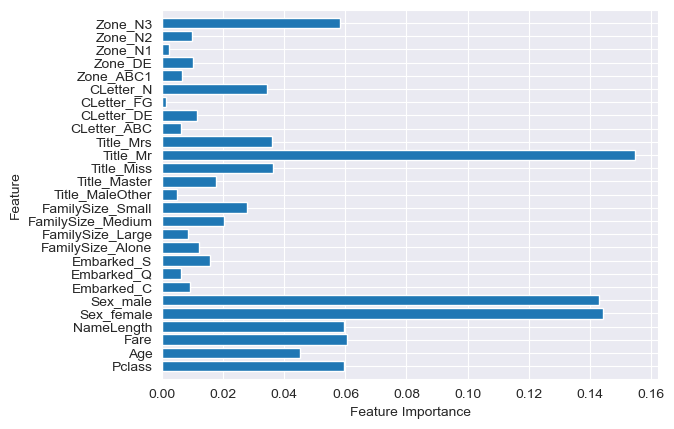

In [57]:
#Lets look at our feature importances
print("Feature Importances: \n{}".format(gs_rf_mod.feature_importances_))
#Plot the Feature Importances
def plot_feature_importances_cancer(model):
    n_features = X_train.shape[1]
    plt.barh(range(n_features), model.feature_importances_, align='center')
    plt.yticks(np.arange(n_features), X_train.columns)
    plt.xlabel("Feature Importance")
    plt.ylabel("Feature")
    plt.ylim(-1, n_features)
plot_feature_importances_cancer(gs_rf_mod)

## Model 4. XGBoost Model

XGBoost is typically one of the best ML models.

In [58]:
#Gradient boosted trees model
import warnings
warnings.filterwarnings('ignore')
from xgboost import XGBClassifier
xgb_mod = XGBClassifier(random_state=42)
xgb_scores = cross_val_stats(X_train, y_train, xgb_mod, 10)

Scores:  [0.75555556 0.85393258 0.6741573  0.85393258 0.85393258 0.76404494
 0.79775281 0.7752809  0.84269663 0.84269663]
Mean:  0.8013982521847689
95% Confidence Interval: [0.7587, 0.8441]


## Model 5. Grid-Searched XGBoost Model

[18:20:41] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "max_features", "min_weight_fraction_leaf" } are not used.

[18:20:41] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "max_features", "min_weight_fraction_leaf" } are not used.

[18:20:41] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "max_features", "min_weight_fraction_leaf" } are not used.

[18:20:41] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "max_features", "min_weight_fraction_leaf" } are not used.

[18:20:41] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "max_features", "min_weight_fraction_leaf" } are not used.

[18:20:41] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "max_features", 

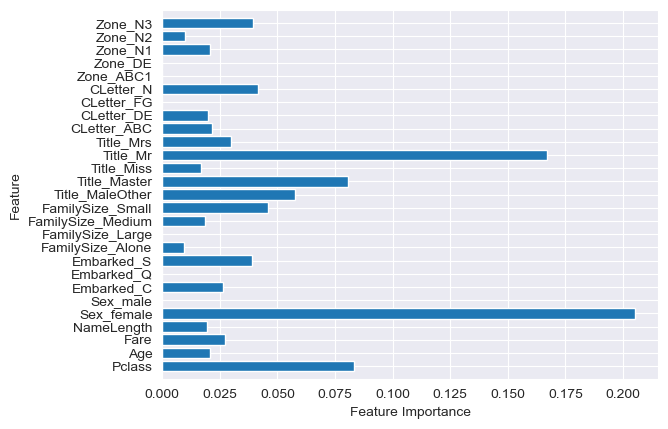

In [66]:
#Grid search XGB model
xgb = XGBClassifier(random_state=42)
grid = GridSearchCV(xgb, cv=5, n_jobs=4, param_grid={
    'n_estimators':[10,20,50,100,250],
    'min_weight_fraction_leaf':[0,0.5,1],
    'gamma':[0.8,0.5,0.9],
    'learning_rate':[1,0.5,0.1,0.05,0.01,],
    'max_features':['sqrt','auto'],
    'subsample':[0.8,0.5,0.7,0.9],
    'max_depth': [1,2,3,4,5]})
grid.fit(X_train, y_train)
grid.best_params_
grid.best_score_

#Cross validate the grid-searched xgboost model
gs_xgb_mod = grid.best_estimator_
gs_xgb_scores = cross_val_stats(X_train, y_train, gs_xgb_mod, 10)
plot_feature_importances_cancer(gs_xgb_mod)

## Model 6. Grid-Searched KNN Model

In [60]:
#Grid search KNN model
from sklearn.neighbors import KNeighborsClassifier
KNN = KNeighborsClassifier()
grid = GridSearchCV(KNN, cv=5, n_jobs=4, param_grid={
    'n_neighbors':[3,5,10,20,30],
    'weights':['uniform','distance'],
    'algorithm':['ball_tree', 'kd_tree', 'brute']})
grid.fit(X_train, y_train)
grid.best_params_
grid.best_score_

#Cross validate the grid-searched xgboost model
gs_KNN_mod = grid.best_estimator_
gs_KNN_scores = cross_val_stats(X_train, y_train, gs_KNN_mod, 10)

Scores:  [0.8        0.84269663 0.78651685 0.84269663 0.86516854 0.79775281
 0.83146067 0.78651685 0.85393258 0.83146067]
Mean:  0.8238202247191012
95% Confidence Interval: [0.8032, 0.8444]


## Model 7. Stacked Regression Model

This is the final model that we will test. It stacks all of the bgest models that we have built in an attempt to yield a uniformly better prediction model.

In [67]:
#The Stacking Model
from sklearn.ensemble import StackingClassifier
stack_mod = StackingClassifier(estimators=[('XGBoost',gs_xgb_mod),('Random Forest',gs_rf_mod),('KNN',gs_KNN_mod)], final_estimator=log_model, cv=5)
stack_scores = cross_val_stats(X_train, y_train, stack_mod, 10)

[18:31:51] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "max_features", "min_weight_fraction_leaf" } are not used.

[18:31:54] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "max_features", "min_weight_fraction_leaf" } are not used.

[18:31:54] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "max_features", "min_weight_fraction_leaf" } are not used.

[18:31:54] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "max_features", "min_weight_fraction_leaf" } are not used.

[18:31:54] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "max_features", "min_weight_fraction_leaf" } are not used.

[18:31:54] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "max_features", 

[18:34:06] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "max_features", "min_weight_fraction_leaf" } are not used.

[18:34:08] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "max_features", "min_weight_fraction_leaf" } are not used.

[18:34:08] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "max_features", "min_weight_fraction_leaf" } are not used.

[18:34:08] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "max_features", "min_weight_fraction_leaf" } are not used.

[18:34:08] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "max_features", "min_weight_fraction_leaf" } are not used.

[18:34:09] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "max_features", 

## Comparison of Models

We can now plot the distribution of the cross-validation scores for each model to obtain a visual understanding of how we can expect each model to perform.

* Overall, all of the models actually seem to have similar performance. This is not typically the case on most datasets, but is normal for the Titanic dataset.
* Although they perfrom similarly, it seems that the best model to choose would be the Logistic Regression model with an average accuracy of about 83.2%. The worst model, surprisingly, is the XGBoost model with an average accuracy of about 81.3%.
* It bears mentioning that this is not definitively the case. We could always perform a more comprehensive grid-search or we could try different approachs in our data processing phase, all of which could change the performance of the models.

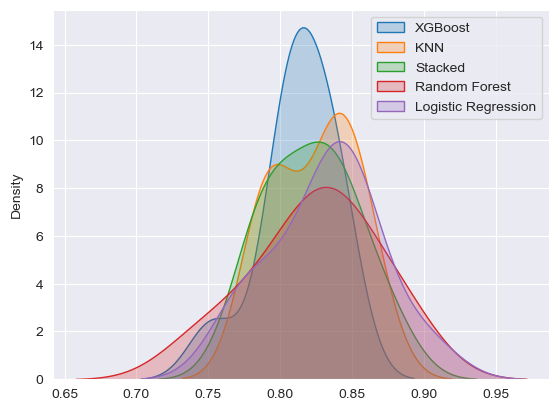

In [68]:
#Plot the performance metrics of the best versions of the models
sns.kdeplot(gs_xgb_scores, shade=True)
sns.kdeplot(gs_KNN_scores, shade=True)
sns.kdeplot(stack_scores, shade=True)
sns.kdeplot(gs_rf_scores, shade=True)
sns.kdeplot(log_model_scores, shade=True)
plt.legend([ 'XGBoost', 'KNN', 'Stacked', 'Random Forest', 'Logistic Regression',])

# Conclusion / Summary

Throughout this notebook, we have walked through the following fundamental steps of any data mining task: (1) Initialization, (2) Visualization, (3) Pre-processing & feature engineering, (4) Post-Processing, (5) Modeling.

* Since this was a classification data mining task with a binary target, we began with a simple model that we knew would yield a 50% accuracy (by randomly guessing).
* Then, by simply looking at the balance (or in this case imbalance) of the target variable, we learned that about 62% of the passengers died. Thus, if we used a model that instead predicted that everyone died, we would have an accuracy of about 62% (an increase of 12%).
* Further, by taking into account a single other variable, namely 'Sex', we were immediately able to achieve an accuracy of about 78.7% (a further increase of about 14.7%).
* Finally, after extensive data processing, feature engineering, profiling, and machine learning, we were able to build a model that yielded an accuracy of about 83.2% (the Logistic Regression model) on average (a further increase of about 4.5%).
* This is an important thing to realize. The bulk of our accuracy came from taking into account a single variable combined with the target. All of the actual 'work' that we did only contributed to an increase of about 4.5% in accuracy. However, this is the name of the game. A 4.5% increase may not seem like much, but it is this ability to squeeze that much more information out of a dataset that makes data scientists valuable in situations where maximizing a data-based metric (in this case accuracy) can potentially have a monetary impact in the millions (or even billions).